# Predicting survival in the ICU

- This aim of this notebook is to develop and optimise 3 machine learning models (logistic regression, decision tree and random forest) to predict the survival of each patient in the ICU
- The data was taken from https://www.kaggle.com/datasets/ukveteran/icu-patients
- There are 5 parts to this notebook, following the assignment instructions
    1. Convert data to tidy format
    2. Export normalised tables to an SQLite3 database
    3. Visualisations
    4. Developing and evaluating models
    5. Summary of findings

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sqlite3

In [2]:
df = pd.read_csv("ICU.csv").drop("Unnamed: 0", axis=1)

In [3]:
df.head()

,ID,Survive,Age,AgeGroup,Sex,Infection,SysBP,Pulse,Emergency
0,4,0,87,3,1,1,80,96,1
1,8,1,27,1,1,1,142,88,1
2,12,1,59,2,0,0,112,80,1
3,14,1,77,3,0,0,100,70,0
4,27,0,76,3,1,1,128,90,1


- There are 200 rows and 9 columns in this dataframe 
- The columns are: 
    - `ID`: Patient identifier
    - `Age`: Patient's age in years
    - `AgeGroup`: Patient's age group
    - `Sex`: Patient's sex. Assume 0 = Male, 1 = Female
    - `Infection`: Boolean value indicating presence of infection
    - `SysBP`: Patient's systolic blood pressure in mmHg
    - `Pulse`: Patient's heart rate in beats/minute
    - `Emergency`: Boolean value indicating whether the patient was an emergency case
    - `Survive`: Boolean value indicating if the patient survived. 
- The target label that we are trying to predict is `Survive`, where 0 = did not survive, and 1 = survive

## 1. Convert data to tidy format


- The current dataset is not tidy because age information is represented in two columns - `Age` and `AgeGroup`
- This leads to redundancy and potential inconsistencies
- Hence `AgeGroup` column was dropped to ensure that data is in a tidy format

In [4]:
df = df.drop("AgeGroup", axis=1)

## 2. Export normalised tables in an SQLite3 database

- The data was represented in a database (icu.db) with normalised tables
- 3 tables were created in 3NF
    1. Patient
        - Columns: `id` (primary key), `age`, `sex`
        - Each row represents 1 patient
    2. Vital_Signs
        - Columns: `id` (primary key), `visit_id` (foreign key to ICU_Visit.id), `systolic_bp`, `pulse_rate`
        - Each row represents 1 instance of vital signs taking
    3. ICU_Visit
        - Columns: `id` (primary key), `patient_id` (foreign key to Patient.id), `infection`, `emergency`, `survival`
        - Each row represents 1 ICU visit


In [5]:
db_conn = sqlite3.connect("icu.db")
c = db_conn.cursor()

In [6]:
# Create Patient table
c.execute(
    """
    CREATE TABLE IF NOT EXISTS Patient (
        id INTEGER PRIMARY KEY,
        age INTEGER,
        sex INTEGER
     )
    """
)

In [7]:
# Create Vital_Sign table
c.execute(
    """
    CREATE TABLE IF NOT EXISTS Vital_Signs (
        id INTEGER PRIMARY KEY,
        visit_id INTEGER,
        systolic_bp INTEGER,
        pulse_rate INTEGER,
        FOREIGN KEY (visit_id) REFERENCES ICU_Visit(id)
    )
    """
)

In [8]:
# Create ICU_Visit table
c.execute(
    """
    CREATE TABLE IF NOT EXISTS ICU_Visit (
        id INTEGER PRIMARY KEY,
        patient_id INTEGER,
        infection BOOLEAN,
        emergency BOOLEAN,
        survival BOOLEAN,
        FOREIGN KEY (patient_id) REFERENCES Patient(id)
    )
    """
)

In [9]:
# Insert data into Patient table
patient_df = df.loc[:, ['ID', 'Age', 'Sex']]
patient_df = patient_df.rename(columns={'ID': 'id', 'Age': 'age', 'Sex': 'sex'})
patient_df.to_sql('Patient', db_conn, if_exists='replace', index=False)

200

In [10]:
# Insert data into ICU_Visit table
ICU_df = df.loc[:, ['ID', 'Infection', 'Emergency', 'Survive']]
ICU_df = ICU_df.rename(columns={'ID': 'patient_id', 'Infection': 'infection', 'Emergency': 'emergency', 'Survive': 'survival'})
ICU_df['id'] = range(1, len(ICU_df) + 1) # Include unique id
ICU_df.to_sql('ICU_Visit', db_conn, if_exists='replace', index=False)


200

In [11]:
# Insert data into Vital_Signs table
VS_df = df.loc[:, ['SysBP', 'Pulse']]
VS_df = VS_df.rename(columns={'SysBP': 'systolic_bp', 'Pulse': 'pulse_rate'})
VS_df['id'] = range(1, len(VS_df) + 1) # Include unique id
VS_df['visit_id'] = range(1, len(ICU_df) + 1)
VS_df.to_sql('Vital_Signs', db_conn, if_exists='replace', index=False)


200

In [12]:
# Close the connection
db_conn.close()

## 3. Visualisations

- Visualisations were created to explore the dataset
- The visualisations created focus on comparing survivors and non-survivors in the dataset, since this was the target label
- SQL statements were used to retrieve data from the db for each visualisation

In [13]:
db_conn = sqlite3.connect("icu.db")
c = db_conn.cursor()

### 3.1 Proportion of survivors vs non-survivors in the dataset

In [14]:
# Get data from db
query = """
SELECT survival
FROM ICU_Visit
"""

df_v0 = pd.read_sql_query(query, db_conn)
df_v0.head()

,survival
0,0
1,1
2,1
3,1
4,0


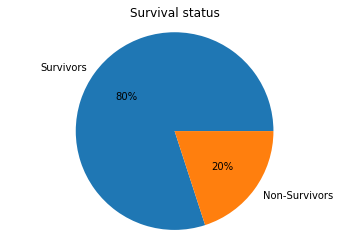

In [15]:
# Count survivors and non-survivors
counts = df_v0['survival'].value_counts()

# Plot pie chart
plt.pie(counts.values, labels=['Survivors', 'Non-Survivors'], autopct='%d%%')
plt.title('Survival status')
plt.axis('equal')
plt.show()


### 3.2 Age distribution of survivors and non-survivors

In [16]:
# Get data from db
query = """
SELECT age, survival
FROM Patient
INNER JOIN ICU_Visit ON Patient.id = ICU_Visit.patient_id
"""

df_v1 = pd.read_sql_query(query, db_conn)
df_v1.head()

,age,survival
0,87,0
1,27,1
2,59,1
3,77,1
4,76,0


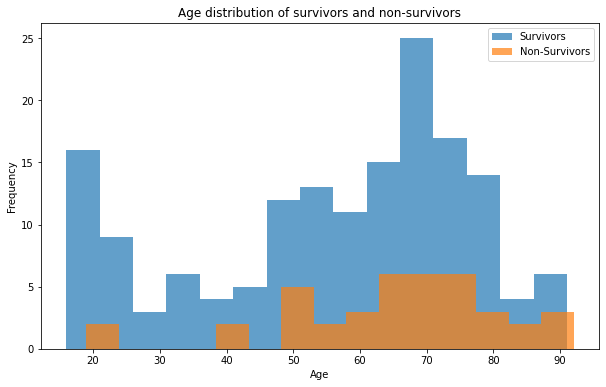

In [17]:
# Separate data into survivors and non-survivors
survivors = df_v1[df_v1['survival'] == 1]
non_survivors = df_v1[df_v1['survival'] == 0]

plt.figure(figsize=(10, 6))

# Plot histogram
plt.hist(survivors['age'], bins=15, alpha=0.7, label='Survivors')
plt.hist(non_survivors['age'], bins=15, alpha=0.7, label='Non-Survivors')

plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age distribution of survivors and non-survivors')
plt.legend(loc='upper right')

plt.show()

### 3.3 Proportion of survivors and non-survivors by sex, presence of infection and presence of emergency

In [18]:
# Get data from db
query = """
SELECT sex, infection, emergency, survival
FROM Patient
INNER JOIN ICU_Visit ON Patient.id = ICU_Visit.patient_id
"""

df_v2 = pd.read_sql_query(query, db_conn)
df_v2.head()

,sex,infection,emergency,survival
0,1,1,1,0
1,1,1,1,1
2,0,0,1,1
3,0,0,0,1
4,1,1,1,0


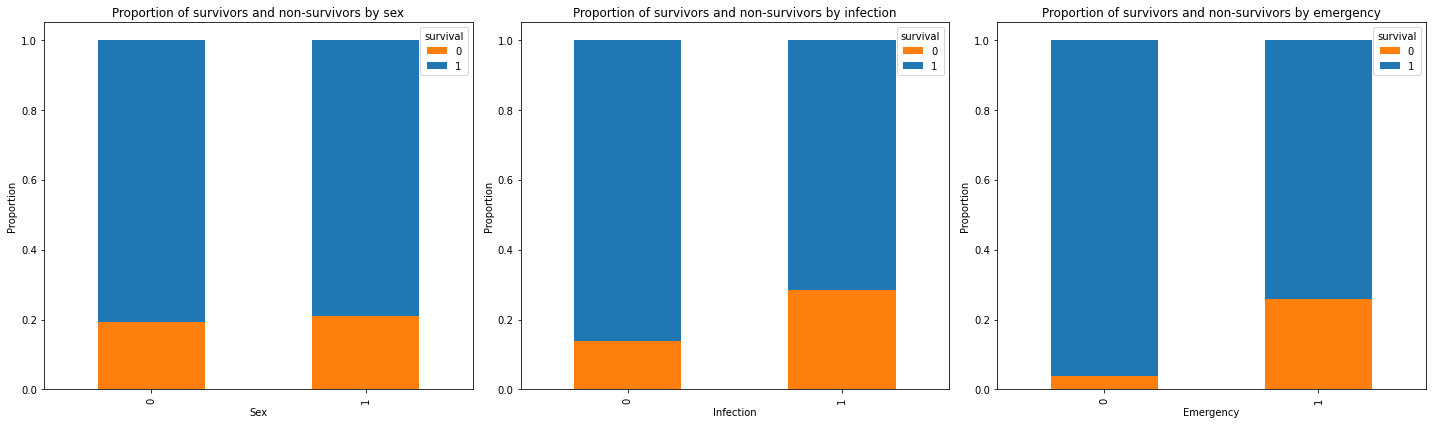

In [19]:
# Define function will help to plot stacked bar charts
def plot_stacked_bar_chart(ax, column_name):
    # Calculate proportion of survivors and non-survivors
    proportions = df_v2.groupby([column_name, 'survival']).size().unstack(fill_value=0)
    proportions = proportions.div(proportions.sum(axis=1), axis=0)

    # Plot stacked bar chart
    proportions.plot(kind='bar', stacked=True, ax=ax, color=['#ff7f0e','#1f77b4'])
    
    ax.set_xlabel(column_name.capitalize())
    ax.set_ylabel('Proportion')
    ax.set_title(f'Proportion of survivors and non-survivors by {column_name}')

# Plot the graphs in the subplots 
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
plot_stacked_bar_chart(axes[0], 'sex')
plot_stacked_bar_chart(axes[1], 'infection')
plot_stacked_bar_chart(axes[2], 'emergency')

plt.tight_layout()

plt.show()


### 3.4 Association between systolic blood pressure and pulse rate in survivors and non-survivors

In [20]:
# Get data from db
query = """
SELECT systolic_bp, pulse_rate, survival
FROM Vital_Signs
INNER JOIN ICU_Visit ON ICU_Visit.id = Vital_Signs.visit_id

"""

df_v3 = pd.read_sql_query(query, db_conn)
df_v3.head()

,systolic_bp,pulse_rate,survival
0,80,96,0
1,142,88,1
2,112,80,1
3,100,70,1
4,128,90,0


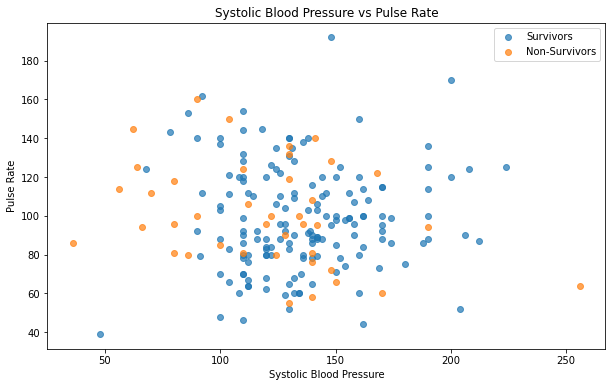

In [21]:
# Separate data into survivors and non-survivors
survivors = df_v3[df_v3['survival'] == 1]
non_survivors = df_v3[df_v3['survival'] == 0]

plt.figure(figsize=(10, 6))

# Plot scatter plot
plt.scatter(survivors['systolic_bp'], survivors['pulse_rate'], label='Survivors', alpha=0.7)
plt.scatter(non_survivors['systolic_bp'], non_survivors['pulse_rate'], label='Non-Survivors', alpha=0.7)

plt.xlabel('Systolic Blood Pressure')
plt.ylabel('Pulse Rate')
plt.title('Systolic Blood Pressure vs Pulse Rate')
plt.legend(loc='upper right')

plt.show()

### 3.5 Summary of visualisations
- 80% (n=160) of patients survived, 20% (n=40) of patients did not survive
- Age distribution appears fairly similar between survivors and non-survivors
- Survival proportion was similar between males and females
- A larger proportion of patients with infection and emergency patients did not survive 
- There does not appear to be a clear relationship between systolic blood pressure and pulse rate in the dataset
- Non-survivors appear to have lower systolic blood pressure compared to survivors

In [22]:
# Close the connection
db_conn.close()

## 4 Developing and evaluating models

- 3 machine learning models (logistic regression, decision tree and random forest) were created to predict the survival of each patient
- The dataframe extracted from the csv file was preprocessed and used to create the models
- Model development and evaluation was done in 5 steps
    1. Dataset preprocessing
    2. Baseline modelling
    3. Feature selection
    4. Hyperparameter tuning
    5. Evaluation on test set


### 4.1 Dataset preprocessing

In [23]:
df.head()

,ID,Survive,Age,Sex,Infection,SysBP,Pulse,Emergency
0,4,0,87,1,1,80,96,1
1,8,1,27,1,1,142,88,1
2,12,1,59,0,0,112,80,1
3,14,1,77,0,0,100,70,0
4,27,0,76,1,1,128,90,1


In [24]:
# Drop columns that are not relevant for mortality prediction
df = df.drop(["ID"], axis=1)

In [25]:
df.head()

,Survive,Age,Sex,Infection,SysBP,Pulse,Emergency
0,0,87,1,1,80,96,1
1,1,27,1,1,142,88,1
2,1,59,0,0,112,80,1
3,1,77,0,0,100,70,0
4,0,76,1,1,128,90,1


In [26]:
# There are no null values in the dataset
df.isna().sum()

Survive      0
Age          0
Sex          0
Infection    0
SysBP        0
Pulse        0
Emergency    0
dtype: int64

In [27]:
# All columns are of int datatype
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Survive    200 non-null    int64
 1   Age        200 non-null    int64
 2   Sex        200 non-null    int64
 3   Infection  200 non-null    int64
 4   SysBP      200 non-null    int64
 5   Pulse      200 non-null    int64
 6   Emergency  200 non-null    int64
dtypes: int64(7)
memory usage: 11.1 KB


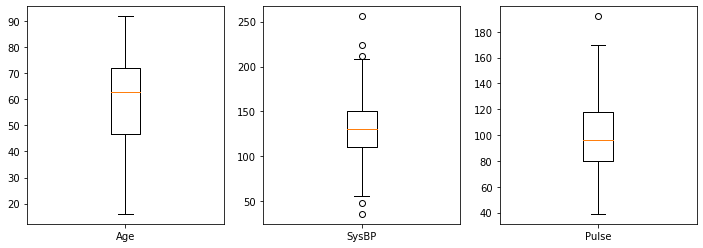

In [28]:
# Checking for outliers in numeric variables
fig, ((ax1, ax2, ax3)) = plt.subplots(nrows=1,ncols=3, figsize=(12, 4))

ax1.boxplot(df['Age'], labels=['Age']);
ax2.boxplot([df['SysBP']], labels=['SysBP']);
ax3.boxplot(df['Pulse'], labels=['Pulse']);

# Outliers present for systolic bp and pulse, but values are still medically plausible hence they are kept

In [29]:
# Check target class balance
# 160 patients survived, 40 patients did not
df["Survive"].value_counts()

1    160
0     40
Name: Survive, dtype: int64

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
# Split data into X and y
X = df.drop("Survive", axis=1)
y = df["Survive"]

In [32]:
# Split into training set (80%) and test set (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [33]:
# Scale the train set and test set because this is required for logistic regression
# Scaled separately to prevent data leakage
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# Keep column names in scaled dataset to help with experimenting with features later
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)


### 4.2 Baseline modelling

- This section produces and compares baseline models for logistic regression, decision tree and random forest to provide a reference for later comparison
- Cross validation was used to get a better estimate of each model's performance

In [34]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [35]:
# Put models in a dictionary
models = {"Logistic Regression": LogisticRegression(max_iter=500),
         "Decision Tree": DecisionTreeClassifier(),
         "Random Forest": RandomForestClassifier()}

# Put scoring metrics in list
metrics = ["accuracy", "precision_macro", "recall_macro", "f1_macro"]

# Create empty DataFrame to populate the name of the classifier and the six metrics returned from cross_validate()
results = pd.DataFrame({
                        "classifier_name":[],
                        "fit_time": [],
                        "score_time": [],
                        "test_accuracy": [],
                        "test_precision_macro": [],
                        "test_recall_macro": [],
                        "test_f1_macro": [],
                        })

In [36]:
# Fit and score models using cross-validation
for name, classifier in models.items():
    
    np.random.seed(42)
    
    # Get the evaluation metrics per fold after cross-validation
    scores_cv = cross_validate(classifier, X_train_scaled, y_train, cv=5, scoring=metrics)

    # Create a dictionary to store the result for the classifier
    dict_this_result = {
                    "classifier_name":[name],
                    }
    # Populate the dictionary with the average cross validation results
    for metric_name, score_per_fold in scores_cv.items():
        dict_this_result[metric_name] = [ scores_cv[metric_name].mean() ]

    # Convert the dictionary to a dataframe
    this_result = pd.DataFrame(dict_this_result)

    # Append this to the main dataframe 
    results = pd.concat([results, this_result], ignore_index=True)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
results

,classifier_name,fit_time,score_time,test_accuracy,test_precision_macro,test_recall_macro,test_f1_macro
0,Logistic Regression,0.004264,0.003975,0.80000,0.672181,0.552440,0.540794
1,Decision Tree,0.001748,0.003363,0.73125,0.589055,0.558103,0.562519
2,Random Forest,0.113324,0.012760,0.81875,0.762213,0.631223,0.647812


In [38]:
metrics_df = results.loc[:,['test_accuracy', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']]

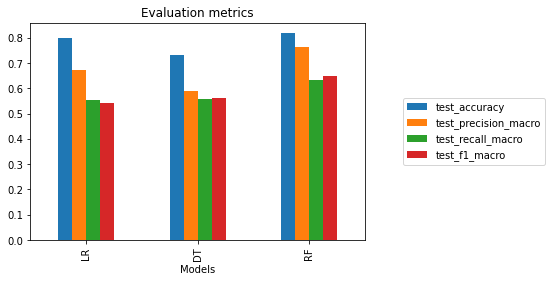

In [39]:
# Plot metrics for easier comparison
metrics_chart = metrics_df.plot.bar()

plt.title("Evaluation metrics")
plt.xlabel("Models")
metrics_chart.set_xticklabels(['LR', 'DT', 'RF'])
metrics_chart.legend(loc='center left',  bbox_to_anchor=(1.1, 0.5))
plt.show()                       


- The best performing model after baseline modelling is the random forest, followed by logistic regression, and then decision tree

### 4.3 Feature selection

- In this section, a random forest is used to evaluate and visualise feature importance
- The 3 least important features for prediction were `Sex`, `Infection` and `Emergency`
- The least important features were systematically dropped to observe its impact on performance

In [40]:
# Fit a random forest classifier
classifier = RandomForestClassifier()
classifier.fit(X_train_scaled, y_train)

RandomForestClassifier()

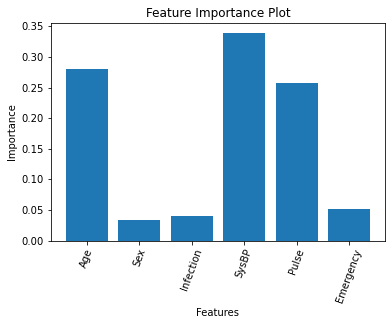

In [41]:
# Plot feature importance
feature_importance = pd.DataFrame({"feature_names" : X_train.columns,
                                   "importance" : classifier.feature_importances_})

plt.bar(feature_importance['feature_names'], feature_importance['importance'])

plt.xlabel('Features')
plt.xticks(rotation=70)
plt.ylabel('Importance')
plt.title('Feature Importance Plot')

plt.show()

In [42]:
# Drop the least important feature, Sex
X_train_scaled_1 = X_train_scaled.drop("Sex", axis=1)
X_test_scaled_1 = X_test_scaled.drop("Sex", axis=1)

In [43]:
# Fit and score models
for name, classifier in models.items():
    
    np.random.seed(42)
    
    # Get the evaluation metrics per fold after cross-validation
    scores_cv = cross_validate(classifier, X_train_scaled_1, y_train, cv=5, scoring=metrics)

    # Create a dictionary to store the result for the classifier
    dict_this_result = {
                    "classifier_name":[name + " (w/o sex)"],
                    }
    # Populate the dictionary with the average cross validation results
    for metric_name, score_per_fold in scores_cv.items():
        dict_this_result[metric_name] = [ scores_cv[metric_name].mean() ]

    # Convert the dictionary to a dataframe
    this_result = pd.DataFrame(dict_this_result)

    # Append this to the main dataframe 
    results = pd.concat([results, this_result], ignore_index=True)


In [44]:
results

,classifier_name,fit_time,score_time,test_accuracy,test_precision_macro,test_recall_macro,test_f1_macro
0,Logistic Regression,0.004264,0.003975,0.80000,0.672181,0.552440,0.540794
1,Decision Tree,0.001748,0.003363,0.73125,0.589055,0.558103,0.562519
2,Random Forest,0.113324,0.012760,0.81875,0.762213,0.631223,0.647812
3,Logistic Regression (w/o sex),0.004781,0.004320,0.80000,0.773897,0.562725,0.565206
4,Decision Tree (w/o sex),0.001981,0.003605,0.71250,0.573884,0.561612,0.563495
5,Random Forest (w/o sex),0.104759,0.011675,0.81250,0.748461,0.601890,0.616912


In [45]:
# Drop the second least important feature, Infection
X_train_scaled_2 = X_train_scaled_1.drop("Infection", axis=1)
X_test_scaled_2 = X_test_scaled_1.drop("Infection", axis=1)

In [46]:
# Fit and score models
for name, classifier in models.items():
    
    np.random.seed(42)
    
    # Get the evaluation metrics per fold after cross-validation
    scores_cv = cross_validate(classifier, X_train_scaled_2, y_train, cv=5, scoring=metrics)

    # Create a dictionary to store the result for the classifier
    dict_this_result = {
                    "classifier_name":[name + " (w/o infection, sex)"],
                    }
    # Populate the dictionary with the average cross validation results
    for metric_name, score_per_fold in scores_cv.items():
        dict_this_result[metric_name] = [ scores_cv[metric_name].mean() ]

    # Convert the dictionary to a dataframe
    this_result = pd.DataFrame(dict_this_result)

    # Append this to the main dataframe 
    results = pd.concat([results, this_result], ignore_index=True)


In [47]:
results

,classifier_name,fit_time,score_time,test_accuracy,test_precision_macro,test_recall_macro,test_f1_macro
0,Logistic Regression,0.004264,0.003975,0.80000,0.672181,0.552440,0.540794
1,Decision Tree,0.001748,0.003363,0.73125,0.589055,0.558103,0.562519
2,Random Forest,0.113324,0.012760,0.81875,0.762213,0.631223,0.647812
3,Logistic Regression (w/o sex),0.004781,0.004320,0.80000,0.773897,0.562725,0.565206
4,Decision Tree (w/o sex),0.001981,0.003605,0.71250,0.573884,0.561612,0.563495
5,Random Forest (w/o sex),0.104759,0.011675,0.81250,0.748461,0.601890,0.616912
6,"Logistic Regression (w/o infection, sex)",0.004464,0.003198,0.81875,0.859032,0.572190,0.577665
7,"Decision Tree (w/o infection, sex)",0.001541,0.002724,0.66875,0.500732,0.498300,0.497825
8,"Random Forest (w/o infection, sex)",0.114932,0.013267,0.80000,0.695290,0.619223,0.631971


- It appears that dropping the least important features generally did not improve the performance of the model
- Hence, no features were dropped from the dataset used to train later models

### 4.4 Hyperparameter tuning

- RandomizedSearchCV was used to find optimal hyperparameters for the models

In [48]:
# Hyperparameter grid for random forest
rf_grid = {"n_estimators" : np.arange(100, 1000, 50),
           "max_depth": [None, 5, 10, 15],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2)}


# Hyperparameter grid for logistic regression
lr_grid = {"C": np.logspace(-4, 4, 20),
           "penalty": ["l1", "l2"],
           "solver": ["liblinear"]}

# Hyperparameter grid for decision tree
dt_grid = {'max_depth': [5, 10, 15, 20, None],
                   'min_samples_split': [2, 5, 10],
                   'min_samples_leaf': [1, 2, 4],
                   'max_features': ['sqrt', 'log2', None]}

In [49]:
# Tune random forest 
np.random.seed(42)

# Instantiate RandomizedSearchCV
rs_rf = RandomizedSearchCV(RandomForestClassifier(),
                    param_distributions=rf_grid,
                    cv=5,
                    n_iter=20,
                    verbose=1)

# Fit to data
rs_rf.fit(X_train_scaled, y_train)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'max_depth': [None, 5, 10, 15],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700,
       750, 800, 850, 900, 950])},
                   verbose=1)

In [50]:
# Best score found
rs_rf.best_score_

0.825

In [51]:
# Best estimator found
rs_rf.best_estimator_

RandomForestClassifier(min_samples_split=16, n_estimators=300)

In [52]:
# Tune LogisticRegression 
np.random.seed(42)

# Instantiate RandomizedSearchCV
rs_log_reg = RandomizedSearchCV(LogisticRegression(), 
                                param_distributions=lr_grid,
                                cv=5,
                                n_iter=20,
                                verbose=True)

# Fit random hyperparameter search model for LogisticRegression
rs_log_reg.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=20,
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'penalty': ['l1', 'l2'],
                                        'solver': ['liblinear']},
                   verbose=True)

In [53]:
# Best score found
rs_log_reg.best_score_

0.8

In [54]:
# Best estimator found
rs_log_reg.best_estimator_

LogisticRegression(C=29.763514416313132, penalty='l1', solver='liblinear')

In [55]:
# Tune Decision Tree
np.random.seed(42)

# Instantiate RandomizedSearchCV
rs_dt = RandomizedSearchCV(DecisionTreeClassifier(), 
                                param_distributions=dt_grid,
                                cv=5,
                                n_iter=20,
                                verbose=True)

# Fit to data
rs_dt.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_iter=20,
                   param_distributions={'max_depth': [5, 10, 15, 20, None],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10]},
                   verbose=True)

In [56]:
# Best score found
rs_dt.best_score_

0.7875

In [57]:
# Best estimator found
rs_dt.best_estimator_

DecisionTreeClassifier(max_depth=5, max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=5)

In [58]:
# Compile best score for each model and print results
tuning_results = {"Random Forest": [rs_rf.best_score_],
                  "Logistic Regression": [rs_log_reg.best_score_],
                  "Decision Tree": [rs_dt.best_score_] }

tuning_df = pd.DataFrame(tuning_results, index=['Best score'])
tuning_df

,Random Forest,Logistic Regression,Decision Tree
Best score,0.825,0.8,0.7875


- The best performing model after hyperparameter tuning is the random forest, followed by logistic regression and then decision

### 4.5 Evaluate on the test set

- The best performing models for random forest, logistic regression and decision tree were evlauated on the test set

In [59]:
# Put models in a dictionary
final_models = {"Logistic Regression": rs_log_reg.best_estimator_,
             "Decision Tree": rs_dt.best_estimator_  ,
             "Random Forest": rs_rf.best_estimator_}

test_results = []

In [60]:
# Fit and score models
for name, classifier in final_models.items():
    
    np.random.seed(42)
    
    # Fit classifier 
    classifier.fit(X_train_scaled, y_train)
    
    # Calculate predicted labels
    y_predicted = classifier.predict(X_test_scaled)
    
    # Calculate evaluation metrics 
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='macro')
    recall = recall_score(y_test, y_predicted, average='macro')
    f1 = f1_score(y_test, y_predicted, average='macro')
    
    # Organise metrics in dictionary
    this_result = {'Classifier': name, 'Accuracy': accuracy, 'Precision' : precision, 'Recall':recall, 'F1-score' : f1}
    test_results.append(this_result)

# Convert to dataframe
test_results_df = pd.DataFrame(test_results)

In [61]:
test_results_df

,Classifier,Accuracy,Precision,Recall,F1-score
0,Logistic Regression,0.850,0.923077,0.571429,0.583333
1,Decision Tree,0.750,0.567100,0.567100,0.567100
2,Random Forest,0.775,0.541667,0.525974,0.525692


## 5 Summary of findings

- Although the random forest performed best after baseline modelling and hyperparameter tuning on the training set, the logistic regression outperformed the other models on the test set across accuracy, precision, recall and F1 scores
- For all models, recall scores were average (50%+), indicating that a considerable number of false negatives (patients predicted not to survive, but survived)
- Additional things that can be explored:
    - Collect more data, collect data on more meaningful features and perform feature engineering using domain knowledge 
    - Explore techniques to address class imbalance
    - Try different machine learning models (e.g. XGBoost, CatBoost)
    - Use GridSearchCV for more fine-grained hyperparameter tuning
